In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel_Regularization'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel_Regularization(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(dataset.X_text.shape[1], 32),
            nn.ReLU(),
            nn.Dropout(.5),
            # nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(.5),
            # nn.BatchNorm1d(64),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(.5),
            # nn.BatchNorm1d(26),
            nn.Linear(16, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel_Regularization().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 4001


In [13]:
# # Do not train if already trained
# if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
#     # Load optimal weights and history
#     model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
#     history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
#     print('Skipping training and loading optimal weights from previous training!')
# else:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.001, weight_decay=0.0001),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=100,
    patience=100,
    delta=0,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 646/646 [00:00<00:00, 1461.18it/s]


Epoch   1/100: RMSE_train: 1,701,962, RMSE_val: 1,569,030


100%|██████████| 646/646 [00:00<00:00, 1547.22it/s]


Epoch   2/100: RMSE_train: 1,277,481, RMSE_val: 1,247,552


100%|██████████| 646/646 [00:00<00:00, 1537.03it/s]


Epoch   3/100: RMSE_train: 1,109,765, RMSE_val: 1,212,838


100%|██████████| 646/646 [00:00<00:00, 1550.09it/s]


Epoch   4/100: RMSE_train: 1,085,243, RMSE_val: 1,176,100


100%|██████████| 646/646 [00:00<00:00, 1541.08it/s]


Epoch   5/100: RMSE_train: 1,071,655, RMSE_val: 1,145,733


100%|██████████| 646/646 [00:00<00:00, 1552.07it/s]


Epoch   6/100: RMSE_train: 1,064,467, RMSE_val: 1,113,243


100%|██████████| 646/646 [00:00<00:00, 1549.49it/s]


Epoch   7/100: RMSE_train: 1,039,896, RMSE_val: 1,092,253


100%|██████████| 646/646 [00:00<00:00, 1550.38it/s]


Epoch   8/100: RMSE_train: 1,046,668, RMSE_val: 1,070,385


100%|██████████| 646/646 [00:00<00:00, 1548.65it/s]


Epoch   9/100: RMSE_train: 1,038,425, RMSE_val: 1,050,007


100%|██████████| 646/646 [00:00<00:00, 1495.38it/s]


Epoch  10/100: RMSE_train: 1,030,803, RMSE_val: 1,033,156


100%|██████████| 646/646 [00:00<00:00, 1551.35it/s]


Epoch  11/100: RMSE_train: 1,037,809, RMSE_val: 1,012,076


100%|██████████| 646/646 [00:00<00:00, 1543.75it/s]


Epoch  12/100: RMSE_train: 1,023,734, RMSE_val: 995,693


100%|██████████| 646/646 [00:00<00:00, 1536.02it/s]


Epoch  13/100: RMSE_train: 1,023,257, RMSE_val: 982,497


100%|██████████| 646/646 [00:00<00:00, 1545.33it/s]


Epoch  14/100: RMSE_train: 1,016,328, RMSE_val: 969,750


100%|██████████| 646/646 [00:00<00:00, 1538.71it/s]


Epoch  15/100: RMSE_train: 1,017,572, RMSE_val: 1,057,542
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1548.49it/s]


Epoch  16/100: RMSE_train: 1,009,798, RMSE_val: 953,129


100%|██████████| 646/646 [00:00<00:00, 1545.50it/s]


Epoch  17/100: RMSE_train: 1,016,868, RMSE_val: 951,508


100%|██████████| 646/646 [00:00<00:00, 1539.91it/s]


Epoch  18/100: RMSE_train: 999,476, RMSE_val: 942,472


100%|██████████| 646/646 [00:00<00:00, 1555.15it/s]


Epoch  19/100: RMSE_train: 1,022,892, RMSE_val: 948,189
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1541.75it/s]


Epoch  20/100: RMSE_train: 1,009,053, RMSE_val: 936,160


100%|██████████| 646/646 [00:00<00:00, 1543.59it/s]


Epoch  21/100: RMSE_train: 1,015,003, RMSE_val: 939,500
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1557.76it/s]


Epoch  22/100: RMSE_train: 997,824, RMSE_val: 933,797


100%|██████████| 646/646 [00:00<00:00, 1549.30it/s]


Epoch  23/100: RMSE_train: 999,481, RMSE_val: 933,909
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1569.64it/s]


Epoch  24/100: RMSE_train: 1,001,768, RMSE_val: 940,144
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 1543.66it/s]


Epoch  25/100: RMSE_train: 1,007,282, RMSE_val: 944,265
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 1560.60it/s]


Epoch  26/100: RMSE_train: 999,977, RMSE_val: 929,082


100%|██████████| 646/646 [00:00<00:00, 1542.65it/s]


Epoch  27/100: RMSE_train: 998,536, RMSE_val: 937,293
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1472.66it/s]


Epoch  28/100: RMSE_train: 986,120, RMSE_val: 921,392


100%|██████████| 646/646 [00:00<00:00, 1445.85it/s]


Epoch  29/100: RMSE_train: 993,922, RMSE_val: 928,638
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1475.39it/s]


Epoch  30/100: RMSE_train: 992,848, RMSE_val: 927,714
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 1308.34it/s]


Epoch  31/100: RMSE_train: 1,004,924, RMSE_val: 938,316
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 1422.69it/s]


Epoch  32/100: RMSE_train: 994,141, RMSE_val: 929,153
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 1433.70it/s]


Epoch  33/100: RMSE_train: 992,764, RMSE_val: 934,444
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 1497.45it/s]


Epoch  34/100: RMSE_train: 983,497, RMSE_val: 928,737
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 1534.25it/s]


Epoch  35/100: RMSE_train: 992,659, RMSE_val: 930,785
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 1490.69it/s]


Epoch  36/100: RMSE_train: 990,896, RMSE_val: 928,559
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 1494.75it/s]


Epoch  37/100: RMSE_train: 991,297, RMSE_val: 938,820
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:00<00:00, 1522.42it/s]


Epoch  38/100: RMSE_train: 983,474, RMSE_val: 932,959
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:00<00:00, 1535.57it/s]


Epoch  39/100: RMSE_train: 1,001,149, RMSE_val: 934,432
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:00<00:00, 1526.24it/s]


Epoch  40/100: RMSE_train: 989,517, RMSE_val: 939,286
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:00<00:00, 1481.82it/s]


Epoch  41/100: RMSE_train: 990,551, RMSE_val: 930,917
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:00<00:00, 1512.83it/s]


Epoch  42/100: RMSE_train: 976,762, RMSE_val: 929,458
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:00<00:00, 1517.14it/s]


Epoch  43/100: RMSE_train: 991,463, RMSE_val: 935,808
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:00<00:00, 1549.24it/s]


Epoch  44/100: RMSE_train: 981,153, RMSE_val: 932,895
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:00<00:00, 1528.28it/s]


Epoch  45/100: RMSE_train: 990,531, RMSE_val: 935,854
EarlyStopping counter: 17 out of 100


100%|██████████| 646/646 [00:00<00:00, 1553.53it/s]


Epoch  46/100: RMSE_train: 981,530, RMSE_val: 934,138
EarlyStopping counter: 18 out of 100


100%|██████████| 646/646 [00:00<00:00, 1558.99it/s]


Epoch  47/100: RMSE_train: 980,847, RMSE_val: 934,838
EarlyStopping counter: 19 out of 100


100%|██████████| 646/646 [00:00<00:00, 1555.18it/s]


Epoch  48/100: RMSE_train: 984,411, RMSE_val: 939,601
EarlyStopping counter: 20 out of 100


100%|██████████| 646/646 [00:00<00:00, 1512.06it/s]


Epoch  49/100: RMSE_train: 981,861, RMSE_val: 940,327
EarlyStopping counter: 21 out of 100


100%|██████████| 646/646 [00:00<00:00, 1558.52it/s]


Epoch  50/100: RMSE_train: 984,816, RMSE_val: 933,583
EarlyStopping counter: 22 out of 100


100%|██████████| 646/646 [00:00<00:00, 1572.89it/s]


Epoch  51/100: RMSE_train: 987,241, RMSE_val: 942,028
EarlyStopping counter: 23 out of 100


100%|██████████| 646/646 [00:00<00:00, 1518.73it/s]


Epoch  52/100: RMSE_train: 984,606, RMSE_val: 933,319
EarlyStopping counter: 24 out of 100


100%|██████████| 646/646 [00:00<00:00, 1565.89it/s]


Epoch  53/100: RMSE_train: 985,259, RMSE_val: 936,740
EarlyStopping counter: 25 out of 100


100%|██████████| 646/646 [00:00<00:00, 1573.38it/s]


Epoch  54/100: RMSE_train: 981,307, RMSE_val: 934,930
EarlyStopping counter: 26 out of 100


100%|██████████| 646/646 [00:00<00:00, 1575.64it/s]


Epoch  55/100: RMSE_train: 991,867, RMSE_val: 952,230
EarlyStopping counter: 27 out of 100


100%|██████████| 646/646 [00:00<00:00, 1573.45it/s]


Epoch  56/100: RMSE_train: 978,407, RMSE_val: 937,175
EarlyStopping counter: 28 out of 100


100%|██████████| 646/646 [00:00<00:00, 1522.88it/s]


Epoch  57/100: RMSE_train: 990,469, RMSE_val: 943,872
EarlyStopping counter: 29 out of 100


100%|██████████| 646/646 [00:00<00:00, 1461.99it/s]


Epoch  58/100: RMSE_train: 975,634, RMSE_val: 942,259
EarlyStopping counter: 30 out of 100


100%|██████████| 646/646 [00:00<00:00, 1445.64it/s]


Epoch  59/100: RMSE_train: 967,373, RMSE_val: 939,153
EarlyStopping counter: 31 out of 100


100%|██████████| 646/646 [00:00<00:00, 1452.65it/s]


Epoch  60/100: RMSE_train: 970,483, RMSE_val: 947,736
EarlyStopping counter: 32 out of 100


100%|██████████| 646/646 [00:00<00:00, 1478.67it/s]


Epoch  61/100: RMSE_train: 963,068, RMSE_val: 944,228
EarlyStopping counter: 33 out of 100


100%|██████████| 646/646 [00:00<00:00, 1524.17it/s]


Epoch  62/100: RMSE_train: 969,587, RMSE_val: 939,937
EarlyStopping counter: 34 out of 100


100%|██████████| 646/646 [00:00<00:00, 1545.93it/s]


Epoch  63/100: RMSE_train: 960,080, RMSE_val: 938,919
EarlyStopping counter: 35 out of 100


100%|██████████| 646/646 [00:00<00:00, 1550.93it/s]


Epoch  64/100: RMSE_train: 958,909, RMSE_val: 939,322
EarlyStopping counter: 36 out of 100


100%|██████████| 646/646 [00:00<00:00, 1513.42it/s]


Epoch  65/100: RMSE_train: 959,525, RMSE_val: 940,772
EarlyStopping counter: 37 out of 100


100%|██████████| 646/646 [00:00<00:00, 1554.69it/s]


Epoch  66/100: RMSE_train: 956,865, RMSE_val: 948,183
EarlyStopping counter: 38 out of 100


100%|██████████| 646/646 [00:00<00:00, 1571.98it/s]


Epoch  67/100: RMSE_train: 959,380, RMSE_val: 937,331
EarlyStopping counter: 39 out of 100


100%|██████████| 646/646 [00:00<00:00, 1552.22it/s]


Epoch  68/100: RMSE_train: 949,888, RMSE_val: 950,633
EarlyStopping counter: 40 out of 100


100%|██████████| 646/646 [00:00<00:00, 1431.54it/s]


Epoch  69/100: RMSE_train: 961,665, RMSE_val: 948,109
EarlyStopping counter: 41 out of 100


100%|██████████| 646/646 [00:00<00:00, 1456.32it/s]


Epoch  70/100: RMSE_train: 954,232, RMSE_val: 936,770
EarlyStopping counter: 42 out of 100


100%|██████████| 646/646 [00:00<00:00, 1452.13it/s]


Epoch  71/100: RMSE_train: 951,570, RMSE_val: 946,598
EarlyStopping counter: 43 out of 100


100%|██████████| 646/646 [00:00<00:00, 1390.10it/s]


Epoch  72/100: RMSE_train: 956,714, RMSE_val: 952,447
EarlyStopping counter: 44 out of 100


100%|██████████| 646/646 [00:00<00:00, 1442.41it/s]


Epoch  73/100: RMSE_train: 947,823, RMSE_val: 953,777
EarlyStopping counter: 45 out of 100


100%|██████████| 646/646 [00:00<00:00, 1492.84it/s]


Epoch  74/100: RMSE_train: 951,600, RMSE_val: 943,194
EarlyStopping counter: 46 out of 100


100%|██████████| 646/646 [00:00<00:00, 1507.55it/s]


Epoch  75/100: RMSE_train: 948,172, RMSE_val: 948,416
EarlyStopping counter: 47 out of 100


100%|██████████| 646/646 [00:00<00:00, 1538.05it/s]


Epoch  76/100: RMSE_train: 965,625, RMSE_val: 942,734
EarlyStopping counter: 48 out of 100


100%|██████████| 646/646 [00:00<00:00, 1554.07it/s]


Epoch  77/100: RMSE_train: 952,101, RMSE_val: 946,912
EarlyStopping counter: 49 out of 100


100%|██████████| 646/646 [00:00<00:00, 1558.38it/s]


Epoch  78/100: RMSE_train: 950,124, RMSE_val: 953,507
EarlyStopping counter: 50 out of 100


100%|██████████| 646/646 [00:00<00:00, 1557.91it/s]


Epoch  79/100: RMSE_train: 946,834, RMSE_val: 955,741
EarlyStopping counter: 51 out of 100


100%|██████████| 646/646 [00:00<00:00, 1558.98it/s]


Epoch  80/100: RMSE_train: 942,789, RMSE_val: 952,490
EarlyStopping counter: 52 out of 100


100%|██████████| 646/646 [00:00<00:00, 1564.77it/s]


Epoch  81/100: RMSE_train: 959,671, RMSE_val: 957,679
EarlyStopping counter: 53 out of 100


100%|██████████| 646/646 [00:00<00:00, 1577.26it/s]


Epoch  82/100: RMSE_train: 958,011, RMSE_val: 968,511
EarlyStopping counter: 54 out of 100


100%|██████████| 646/646 [00:00<00:00, 1572.58it/s]


Epoch  83/100: RMSE_train: 953,644, RMSE_val: 943,311
EarlyStopping counter: 55 out of 100


100%|██████████| 646/646 [00:00<00:00, 1573.53it/s]


Epoch  84/100: RMSE_train: 955,058, RMSE_val: 948,968
EarlyStopping counter: 56 out of 100


100%|██████████| 646/646 [00:00<00:00, 1567.26it/s]


Epoch  85/100: RMSE_train: 963,170, RMSE_val: 950,369
EarlyStopping counter: 57 out of 100


100%|██████████| 646/646 [00:00<00:00, 1560.85it/s]


Epoch  86/100: RMSE_train: 953,801, RMSE_val: 948,660
EarlyStopping counter: 58 out of 100


100%|██████████| 646/646 [00:00<00:00, 1566.66it/s]


Epoch  87/100: RMSE_train: 943,855, RMSE_val: 943,472
EarlyStopping counter: 59 out of 100


100%|██████████| 646/646 [00:00<00:00, 1568.36it/s]


Epoch  88/100: RMSE_train: 954,134, RMSE_val: 947,134
EarlyStopping counter: 60 out of 100


100%|██████████| 646/646 [00:00<00:00, 1571.36it/s]


Epoch  89/100: RMSE_train: 945,608, RMSE_val: 945,794
EarlyStopping counter: 61 out of 100


100%|██████████| 646/646 [00:00<00:00, 1516.35it/s]


Epoch  90/100: RMSE_train: 941,684, RMSE_val: 942,038
EarlyStopping counter: 62 out of 100


100%|██████████| 646/646 [00:00<00:00, 1529.40it/s]


Epoch  91/100: RMSE_train: 942,841, RMSE_val: 944,290
EarlyStopping counter: 63 out of 100


100%|██████████| 646/646 [00:00<00:00, 1559.42it/s]


Epoch  92/100: RMSE_train: 945,613, RMSE_val: 944,301
EarlyStopping counter: 64 out of 100


100%|██████████| 646/646 [00:00<00:00, 1520.00it/s]


Epoch  93/100: RMSE_train: 953,398, RMSE_val: 944,405
EarlyStopping counter: 65 out of 100


100%|██████████| 646/646 [00:00<00:00, 1337.21it/s]


Epoch  94/100: RMSE_train: 945,711, RMSE_val: 947,193
EarlyStopping counter: 66 out of 100


100%|██████████| 646/646 [00:00<00:00, 1521.77it/s]


Epoch  95/100: RMSE_train: 956,410, RMSE_val: 944,156
EarlyStopping counter: 67 out of 100


100%|██████████| 646/646 [00:00<00:00, 1537.61it/s]


Epoch  96/100: RMSE_train: 963,781, RMSE_val: 946,042
EarlyStopping counter: 68 out of 100


100%|██████████| 646/646 [00:00<00:00, 1517.04it/s]


Epoch  97/100: RMSE_train: 949,169, RMSE_val: 945,538
EarlyStopping counter: 69 out of 100


100%|██████████| 646/646 [00:00<00:00, 1534.92it/s]


Epoch  98/100: RMSE_train: 957,166, RMSE_val: 954,713
EarlyStopping counter: 70 out of 100


100%|██████████| 646/646 [00:00<00:00, 1491.05it/s]


Epoch  99/100: RMSE_train: 950,778, RMSE_val: 943,236
EarlyStopping counter: 71 out of 100


100%|██████████| 646/646 [00:00<00:00, 1510.25it/s]

Epoch 100/100: RMSE_train: 945,978, RMSE_val: 941,496
EarlyStopping counter: 72 out of 100


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   808668.953  452823.243  0.539  0.581
val     924560.357  505653.374  0.594  0.442
test    947138.244  509255.634  0.577  0.420
--------------------------------------------
total   850090.774  469392.007  0.552  0.535


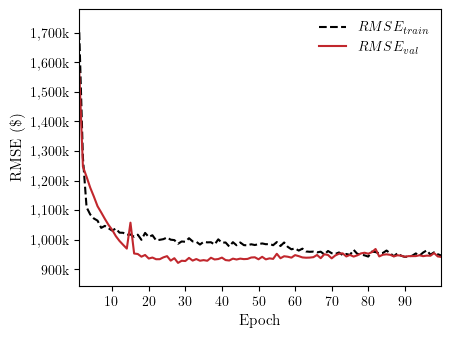

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

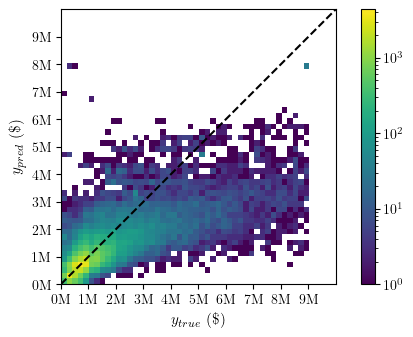

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')